# TOC:
* ## [Naive Bayes Classification](#naive)
* ## [Conditional Random Fields 1](#crf1): pycrfsuite
* ## [Conditional Random Fields 2](#crf2): sklearn_crfsuite
* ## [Conditional Random Fields 3](#crf3): looking for better c1,c2


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import os

documents = []
for doc in os.listdir("training_data"):
    if doc.endswith("ing.csv"):
        documents.append(pd.read_csv("training_data/"+doc))

# Changing size of training data: 200, 400, 600 documents        
documents_604 = documents[:604]   
documents_400 = documents[:400] 
documents_200 = documents[:200]

#documents = documents_200

all_vectors = pd.concat(documents)
len(documents), len(all_vectors)

#Last (81, 110525) 
#Last (125, 174927)
#Current (598, 780720)

(604, 806028)

In [2]:
# Place features in X and types in Y

def get_features(vectors):
    return vectors.drop('type', axis=1)

def get_types(vectors):
    return vectors['type']

def pd_to_dict_list(data):
    return data.to_dict('records')
    #return data.values.tolist()

def pd_type_column_to_string_list(data):
     return [ x for x in data ]
    
X_pd = get_features(all_vectors)
y_pd = get_types(all_vectors)

X_doc_list = [ pd_to_dict_list(get_features(doc)) for doc in documents ]
y_doc_list = [ pd_type_column_to_string_list(get_types(doc)) for doc in documents ]

X_doc_list[0][52], y_doc_list[0][52]

({'awerage_word_length': 5.8125,
  'boldness_first_word': 0.0,
  'formuleness': 0.0,
  'heading_first_word': False,
  'is_capital_first_letter': False,
  'italicness': 0.0,
  'proof_first_word': False,
  'words_num': 16},
 'text')

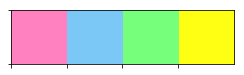

In [12]:
# Plot palette
col_list = ["pink", "lightblue", "lightgreen", "yellow"]
sns.palplot(sns.xkcd_palette(col_list))

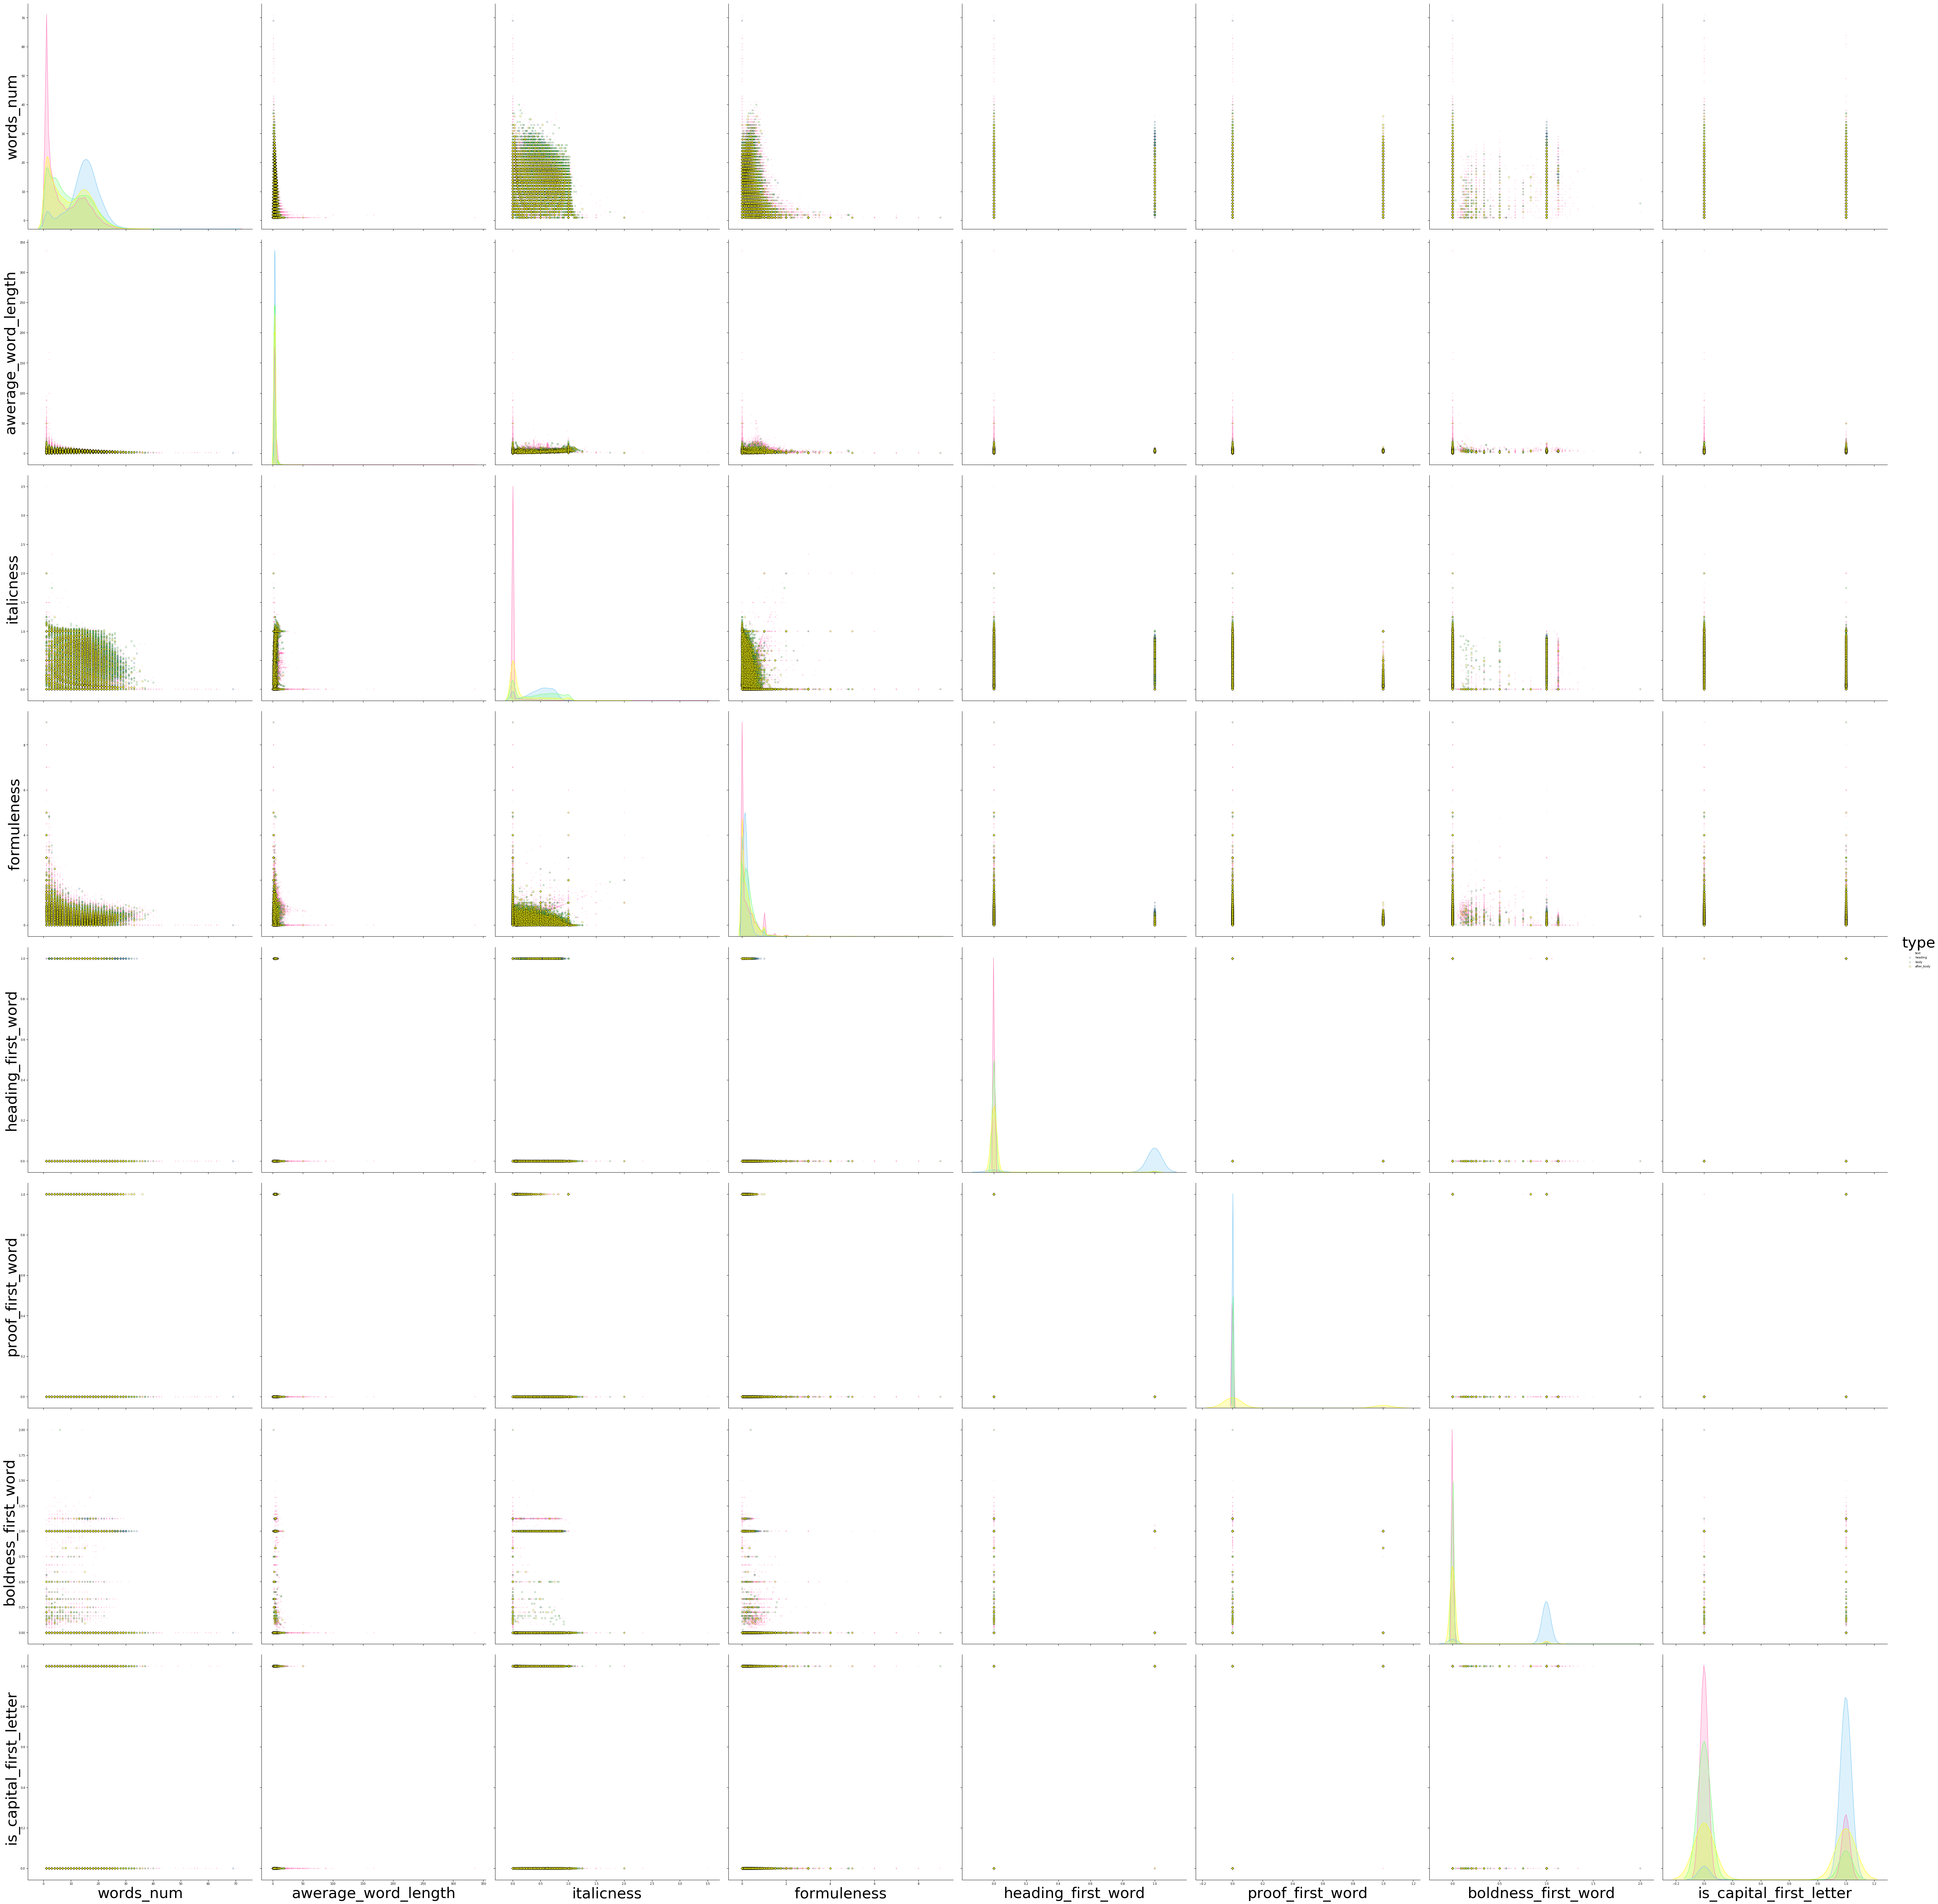

In [13]:
# Plot
col_list_palette = sns.xkcd_palette(col_list)
sns.set_palette(col_list_palette)
sns.set_context("paper", rc={"axes.labelsize":45})
plot=sns.pairplot(
    data=all_vectors, hue="type",
    plot_kws = {'alpha': 0.3, 'edgecolor': 'k'},
    markers = ["+", "o", "s", "D"],
    height=10)
plot._legend.get_title().set_fontsize(45)
plot

In [14]:
# Save plot
plot.savefig("plots/lines_plot_30_604.png")

<a id='naivealgo'></a>
# Naive Handmade Algorithm


In [5]:
from tag_text import *
from sklearn.model_selection import train_test_split

y_model=data_to_tags()

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Works only with all vectors (y_pd)

#print len(y_model), len(y_pd)

print "Handmade algorithm"
print classification_report(y_pd, y_model, digits=2)
#y_pd.merge(y_model, left_on='type', right_on='type', how='outer')
#res=pd.concat([y_pd, y_model], axis=1)
#y_pd, y_model

Handmade algorithm
             precision    recall  f1-score   support

 after_body       0.26      0.22      0.24     14605
       body       0.74      0.30      0.43     32977
    heading       0.71      0.91      0.80      9969
       text       0.96      0.99      0.97    748477

avg / total       0.94      0.94      0.94    806028



<a id='naive'></a>
# Naive Bayes Classification


In [45]:
# Separating data to training and test for all_vectors
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.3)

# Trying Naive Bayes Classification on lines
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(X_train, y_train)                  # 3. fit model to data
y_model = model.predict(X_test)             # 4. predict on new data
y_model_train = model.predict(X_train)
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print "Test data"
print classification_report(y_test, y_model, digits=2)
#print "Training data"
#print classification_report(y_train, y_model_train, digits=2)

Test data
             precision    recall  f1-score   support

 after_body       0.34      0.20      0.25      1360
       body       0.40      0.61      0.48      3025
    heading       0.43      0.93      0.58       993
       text       0.97      0.94      0.96     70883

avg / total       0.93      0.91      0.92     76261



<a id='crf1'></a>
# Conditional Random Fields 1

In [6]:
# Conditional Random Fields 1.1

# Separating data to training and test for documents
X_train, X_test, y_train, y_test = train_test_split(X_doc_list, y_doc_list, test_size=0.3)

import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)

#TODO: debug!!!

# Submit training data to the trainer
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1' : 0.189,
    'c2' : 0.017,

    # maximum number of iterations
    'max_iterations': 100,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Save the model to the file
trainer.train('crf_models/crf.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 48
Seconds required: 0.113

L-BFGS optimization
c1: 0.189000
c2: 0.017000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 564360.657882
Feature norm: 1.000000
Error norm: 450418.967800
Active features: 48
Line search trials: 1
Line search step: 0.000000
Seconds required for this iteration: 0.439

***** Iteration #2 *****
Loss: 515630.805411
Feature norm: 0.898784
Error norm: 437273.579081
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.248

***** Iteration #3 *****
Loss: 139037.452615
Feature norm: 1.834360
Error norm: 308287.979994
Active features: 31
Line search trials: 1
Line search step: 1.000000
Seconds required for this 

***** Iteration #43 *****
Loss: 45107.509123
Feature norm: 13.369671
Error norm: 5128.416974
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.252

***** Iteration #44 *****
Loss: 45082.877255
Feature norm: 13.432638
Error norm: 6477.095455
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.234

***** Iteration #45 *****
Loss: 45041.421801
Feature norm: 13.467284
Error norm: 5383.899063
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.233

***** Iteration #46 *****
Loss: 45033.086735
Feature norm: 13.537147
Error norm: 22116.038073
Active features: 48
Line search trials: 3
Line search step: 0.250000
Seconds required for this iteration: 0.694

***** Iteration #47 *****
Loss: 44980.434051
Feature norm: 13.600125
Error norm: 8932.638063
Active features: 47
Line search trials: 1
Line search step: 1.000000
Seconds requi

***** Iteration #85 *****
Loss: 44721.932921
Feature norm: 14.024534
Error norm: 2036.377145
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.234

***** Iteration #86 *****
Loss: 44719.904901
Feature norm: 14.021291
Error norm: 820.840396
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.242

***** Iteration #87 *****
Loss: 44716.950193
Feature norm: 14.016559
Error norm: 452.084573
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.232

***** Iteration #88 *****
Loss: 44716.310845
Feature norm: 14.016237
Error norm: 4342.911051
Active features: 48
Line search trials: 5
Line search step: 0.062500
Seconds required for this iteration: 1.254

***** Iteration #89 *****
Loss: 44716.000420
Feature norm: 14.009443
Error norm: 7066.371550
Active features: 48
Line search trials: 1
Line search step: 1.000000
Seconds required

In [7]:
# Conditional Random Fields 1.2
tagger = pycrfsuite.Tagger()
tagger.open('crf_models/crf.model')
y_pred = [tagger.tag(xseq) for xseq in X_test]

# Create a mapping of labels to indices
labels = {"heading": 2, "body": 1, "after_body": 0, "text": 3}

import numpy as np
from sklearn.metrics import classification_report

# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions, target_names=[ "after_body", "body", "heading","text"]))

             precision    recall  f1-score   support

 after_body       0.48      0.29      0.36      4382
       body       0.60      0.48      0.53      9841
    heading       0.87      0.81      0.84      2924
       text       0.97      0.98      0.98    226788

avg / total       0.94      0.95      0.95    243935



<a id='crf2'></a>
# Conditional Random Fields 2

In [9]:
#Conditional Random Fields 2.1
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

#TODO: debug!!!

# Separating data to training and test
X_train, X_test, y_train, y_test = train_test_split(X_doc_list, y_doc_list, test_size=0.3)

# Set the parameters of the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
        
    c1 = 0.189,
    c2 = 0.017,
    
    max_iterations=100,
    
    # whether to include transitions that
    # are possible, but not observed
    all_possible_transitions=True
)

crf.fit(X_train, y_train)
y_pred_train = crf.predict(X_train)
y_pred_test = crf.predict(X_test)

#print("Training on the training part")
#print(metrics.flat_classification_report(y_train, y_pred_train, digits=2))
print("CRF")
print(metrics.flat_classification_report(y_test, y_pred_test, digits=2))

CRF
             precision    recall  f1-score   support

 after_body       0.47      0.25      0.33      4268
       body       0.70      0.38      0.49      9755
    heading       0.88      0.75      0.81      2792
       text       0.96      0.99      0.98    222882

avg / total       0.94      0.95      0.94    239697



In [10]:
# Conditional Random Fields 2.2
# Dependencies

from collections import Counter

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])


Top positive:
4.638508 heading  heading_first_word
2.194456 heading  boldness_first_word
1.868191 after_body proof_first_word
0.802440 body     italicness
0.484846 after_body is_capital_first_letter
0.411067 heading  italicness
0.261259 after_body heading_first_word
0.155600 body     formuleness
0.152519 body     heading_first_word
0.092733 body     words_num
0.072059 text     words_num
0.070598 heading  words_num
0.065690 after_body words_num
0.061883 body     awerage_word_length
0.057203 text     awerage_word_length
0.041956 after_body boldness_first_word
0.021420 after_body awerage_word_length
0.004228 text     is_capital_first_letter
-0.022139 heading  is_capital_first_letter
-0.029404 heading  formuleness
-0.113280 text     proof_first_word
-0.200402 text     formuleness
-0.210958 text     boldness_first_word
-0.283388 after_body formuleness
-0.301309 after_body italicness
-0.351070 body     is_capital_first_letter
-0.362004 heading  awerage_word_length
-0.583849 heading  proof_fi

In [11]:
# Conditional Random Fields 2.4
# Transitions

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
text   -> text    2.600802
body   -> body    1.326326
body   -> after_body 1.266201
after_body -> text    1.253203
heading -> body    0.310498
text   -> heading 0.002529
text   -> body    -0.635596
after_body -> heading -0.923327
after_body -> body    -1.287398
body   -> heading -1.677441
heading -> after_body -1.773029
heading -> text    -2.148778
after_body -> after_body -3.166424
heading -> heading -3.396957
text   -> after_body -5.749423
body   -> text    -6.169060

Top unlikely transitions:
text   -> text    2.600802
body   -> body    1.326326
body   -> after_body 1.266201
after_body -> text    1.253203
heading -> body    0.310498
text   -> heading 0.002529
text   -> body    -0.635596
after_body -> heading -0.923327
after_body -> body    -1.287398
body   -> heading -1.677441
heading -> after_body -1.773029
heading -> text    -2.148778
after_body -> after_body -3.166424
heading -> heading -3.396957
text   -> after_body -5.749423
body   -> text    -6.169060


In [20]:
# Conditional Random Fields 2.3
# Dependencies

import matplotlib.pyplot as plt

_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

NameError: name 'rs' is not defined

<a id='crf3'></a>
# Conditional Random Fields 3

In [21]:
# Conditional Random Fields 3.1
# Adjusting c1, c2 to take care of "heading", "body", and "after_body" rather than "text"

# Takes time, +-4min

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

labels = ['heading', 'body', 'after_body']

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=20,
                        scoring=f1_scorer)

rs.fit(X_train, y_train)

#something goes wrong


Fitting 3 folds for each of 20 candidates, totalling 60 fits


Process PoolWorker-3:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/usr/lib/python2.7/dist-packages/joblib/pool.py", line 360, in get
    racquire()
KeyboardInterrupt


KeyboardInterrupt: 

In [49]:
# Conditional Random Fields 3.2
# Check up c1, c2 and build a crf

#previous: 0.18, 0.017
#last: {'c1': 0.28900203043076822, 'c2': 0.015259555421089956}
print rs.best_params_

crf=rs.best_estimator_

crf.fit(X_train, y_train)
y_pred_train = crf.predict(X_train)
y_pred_test = crf.predict(X_test)

print(metrics.flat_classification_report(y_train, y_pred_train, digits=2))

#rs.best_score_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'